In [1]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3
cosmo_params = pickle.load(open('data/cosmo_params.pkl', 'rb'))

In [2]:
def get_mass_function_plots(yerr_dict, params):
    i=0
    fig_axs = {}
    c_params = params | FIXED
    for a in N_data:

        fig1 = plt.figure(figsize =(12, 7))

        axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
        plt.subplots_adjust(wspace=0, hspace=0)
        Pk = mass_function.Pka[a]
        c_data = NvMs[a]

        Ms = M_data[a]
        N = N_data[a]
        edge_pairs = c_data['edge_pairs']

        edges = [edge[0] for edge in edge_pairs]
        edges += [edge_pairs[-1][1]]

        yerr = yerr_dict[a]
        dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


        tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
#             print(tinker_eval_MCMC)

#             f_dndM_MCMC_LOG = interp1d(np.log10(M_numerics), tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)
#             f_dndM_MCMC = lambda x:f_dndM_MCMC_LOG(np.log10(x))
        f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)

        tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])



        axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
        axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')

        edges = np.array(edges)
        axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
                   align='edge', fill=False, ec='black', label='Data')
        axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
        axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')

        y1 = 0.1*np.ones_like(N)
        y1 = np.append(y1, y1[-1])
        y1 = np.append(y1[0], y1)

        y2 = -0.1*np.ones_like(N)
        y2 = np.append(y2, y2[-1])
        y2 = np.append(y2[0], y2)

        c_Ms = np.append(Ms, edges[-1])
        c_Ms = np.append(edges[0], c_Ms)
        axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

        y1 = 0.01*np.ones_like(N)
        y1 = np.append(y1, y1[-1])
        y1 = np.append(y1[0], y1)

        y2 = -0.01*np.ones_like(N)
        y2 = np.append(y2, y2[-1])
        y2 = np.append(y2[0], y2)

        axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].legend(frameon=False)
        axs[0].set_ylabel('N')

        axs[1].set_xscale('log')
        axs[1].set_yscale('symlog', linthresh=1e-2)    
        axs[1].legend(frameon=False)
        axs[1].axhline(0, c='black')
        axs[1].set_ylabel('N')
        axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
        axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
        axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))
        i+=1

        axs[0].set_xlim((200*Mpart, np.max(edges)))
        axs[1].set_xlim((200*Mpart, np.max(edges)))
        axs[1].set_ylim((-1e1, 1e1))
        fig_axs[a] = [fig1, axs]
    return fig_axs

In [3]:
def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [4]:
param_names = [ 'd1','e0' ,'e1','f0', 'g0','g1']

FIXED = {
         'f1':0.12,
         'd0':2.4,
        }

In [5]:
from os.path import exists
params = {}


ndim = len(param_names)
for box in cosmo_params:
    if('Box5_1400' in box): #something weird going on
        continue
    #check if there is a fit for this box by checking if the corresponding figure exsits
    fig_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, 1.0)
    if(not exists(fig_fname)):
        print('Skipping %s'%(box))
        continue
    sampler = None
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
        sampler = pickle.load(f)
    samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
    final_param_vals = np.percentile(samples,  50,axis=0)
    params[box] = dict(zip(param_names, final_param_vals))

Skipping Box12_1400
Skipping Box15_1400
Skipping Box21_1400
Skipping Box22_1400
Skipping Box35_1400
Skipping Box36_1400
Skipping Box47_1400
Skipping Box49_1400
Skipping Box52_1400
Skipping Box54_1400
Skipping Box63_1400
Skipping Box70_1400
Skipping Box82_1400
Skipping Box85_1400
Skipping Box95_1400


In [20]:
def train_test_split(length, split=0.7):
    indices = np.random.permutation(length)
    split_len = int(length*split)
    return indices[:split_len], indices[split_len:]

In [21]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [22]:
X, Y = [], []
for box in params:
    X += [list(cosmo_params[box].values())]
    Y += [list(params[box].values())]
X = np.array(X)
Y = np.array(Y)

training_idx, testing_idx = train_test_split(len(X), split=0.9)
X_train, X_test = X[training_idx], X[testing_idx]
Y_train, Y_test = Y[training_idx], Y[testing_idx]

box_train = np.array(list(params.keys()))[training_idx]
box_test = np.array(list(params.keys()))[testing_idx]


X_train, X_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float()
Y_train, Y_test = torch.from_numpy(Y_train).float(), torch.from_numpy(Y_test).float()

n_tasks = len(Y_train[0])

In [23]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=n_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]), num_tasks=n_tasks, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks)
model = MultitaskGPModel(X_train, Y_train, likelihood)

In [24]:
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [25]:
training_iterations = 300
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/300 - Loss: 1.403
Iter 2/300 - Loss: 1.347
Iter 3/300 - Loss: 1.291
Iter 4/300 - Loss: 1.238
Iter 5/300 - Loss: 1.185
Iter 6/300 - Loss: 1.133
Iter 7/300 - Loss: 1.082
Iter 8/300 - Loss: 1.031
Iter 9/300 - Loss: 0.980
Iter 10/300 - Loss: 0.929
Iter 11/300 - Loss: 0.879
Iter 12/300 - Loss: 0.829
Iter 13/300 - Loss: 0.780
Iter 14/300 - Loss: 0.731
Iter 15/300 - Loss: 0.683
Iter 16/300 - Loss: 0.635
Iter 17/300 - Loss: 0.588
Iter 18/300 - Loss: 0.540
Iter 19/300 - Loss: 0.493
Iter 20/300 - Loss: 0.446
Iter 21/300 - Loss: 0.400
Iter 22/300 - Loss: 0.355
Iter 23/300 - Loss: 0.310
Iter 24/300 - Loss: 0.266
Iter 25/300 - Loss: 0.223
Iter 26/300 - Loss: 0.180
Iter 27/300 - Loss: 0.137
Iter 28/300 - Loss: 0.094
Iter 29/300 - Loss: 0.053
Iter 30/300 - Loss: 0.012
Iter 31/300 - Loss: -0.028
Iter 32/300 - Loss: -0.066
Iter 33/300 - Loss: -0.104
Iter 34/300 - Loss: -0.140
Iter 35/300 - Loss: -0.176
Iter 36/300 - Loss: -0.212
Iter 37/300 - Loss: -0.247
Iter 38/300 - Loss: -0.282
Iter 39/300 -

Iter 300/300 - Loss: -1.218


In [26]:
from utils import *
from massfunction import *

In [27]:
import random

box =random.choice(box_test)

mass_function = MassFunction(cosmo_params[box])

In [28]:
# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test))
    samples = predictions.sample(torch.Size([1000])) 
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
print(box_test.shape, mean.shape)
print(box_test.shape, np.transpose(samples, axes=[1,0,2]).shape)

mean = dict(zip(box_test, mean))
samples = dict(zip(box_test, np.transpose(samples, axes=[1,0,2])))

(14,) torch.Size([14, 6])
(14,) torch.Size([14, 1000, 6])


In [29]:
NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(NvMs.keys()):
#     if(a != 1): #TEST
#         continue
        
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    mass_function.compute_dlnsinvdM(a)

  0%|          | 0/16 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and ca

In [30]:
M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

In [31]:
a_list = list(NvMs.keys())

100%|██████████| 1000/1000 [00:04<00:00, 239.95it/s]
/tmp/ipykernel_16270/3911572351.py:99: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')
  0%|          | 0/1000 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing t

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/tmp/ipykernel_16270/3911572351.py:99: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')
  0%|          | 0/1000 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analy

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/tmp/ipykernel_16270/3911572351.py:99: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')
  0%|          | 0/1000 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analy

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subrang

/tmp/ipykernel_16270/3911572351.py:99: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


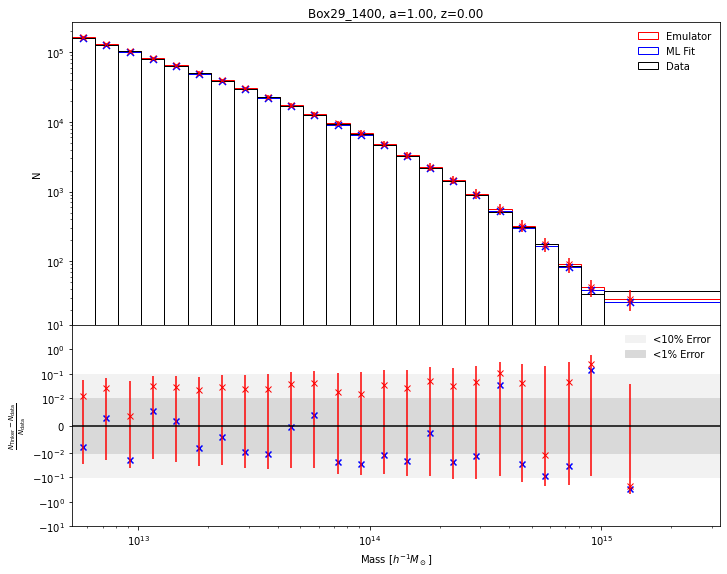

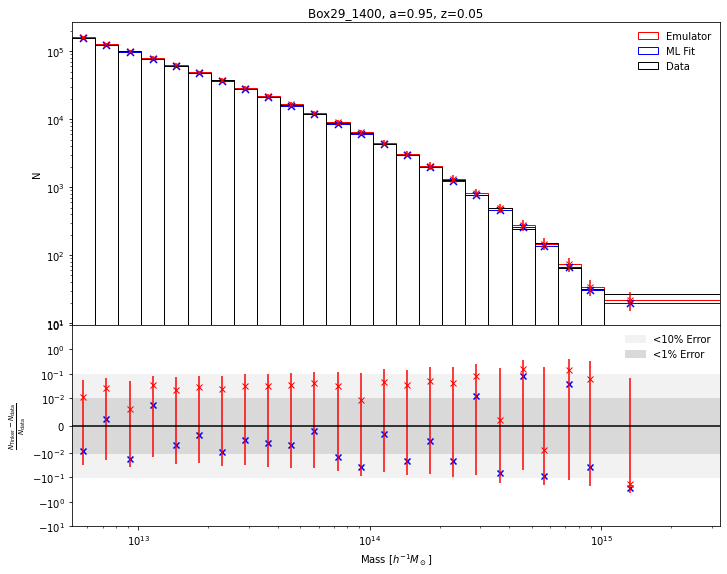

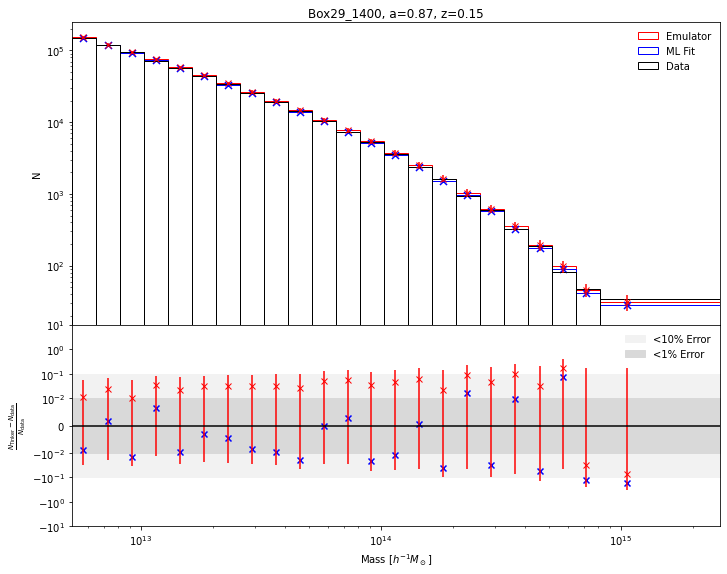

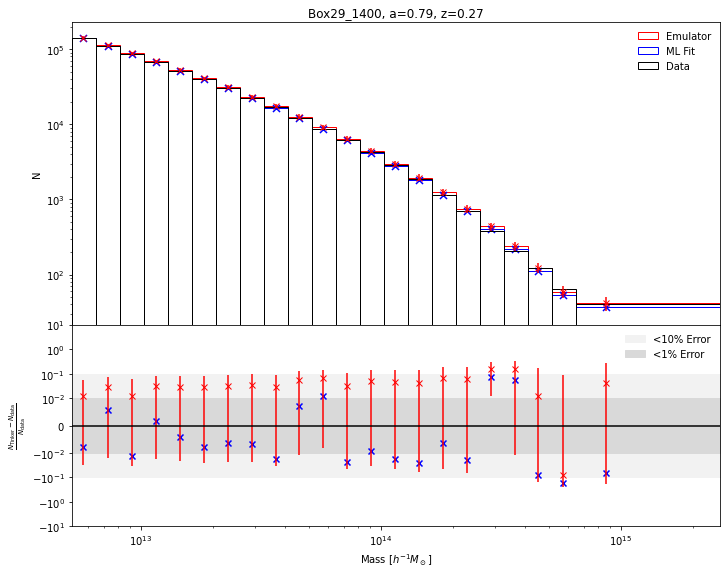

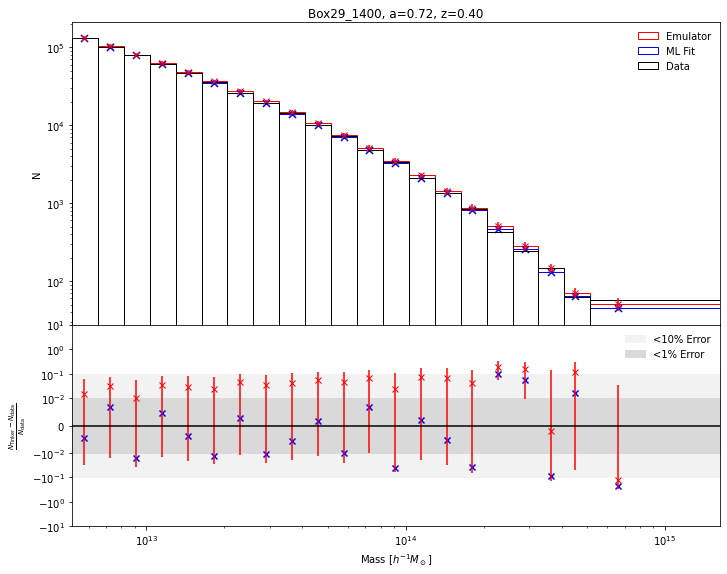

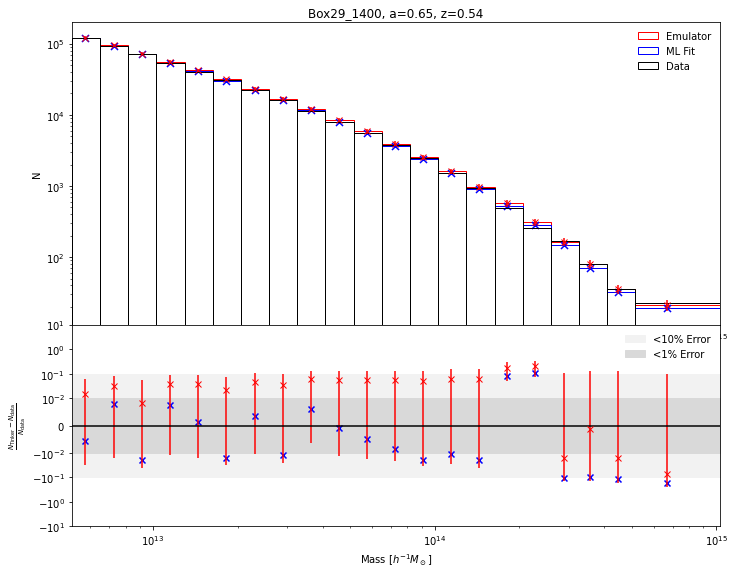

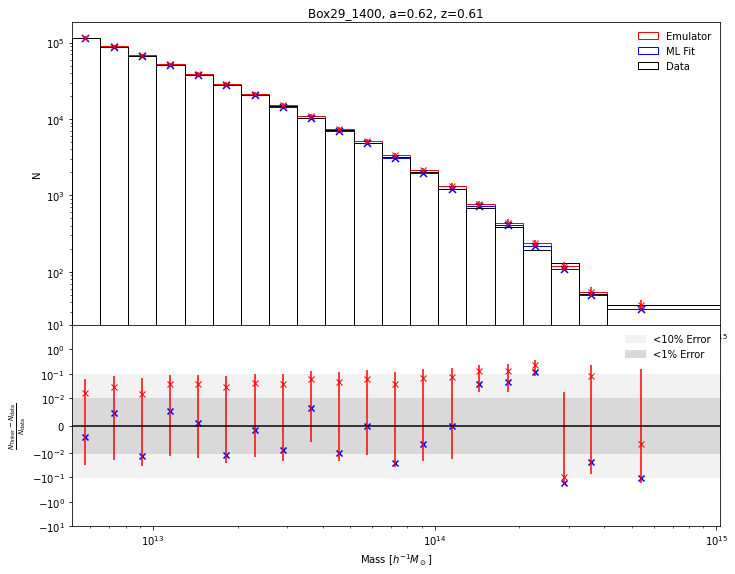

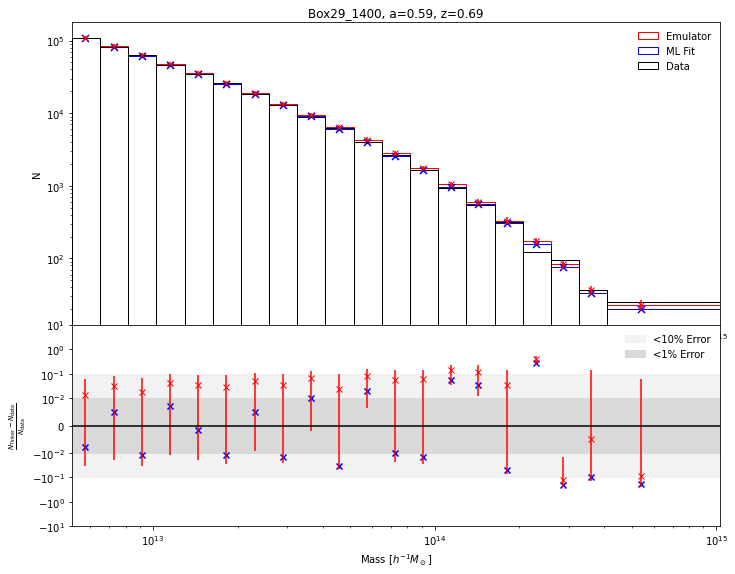

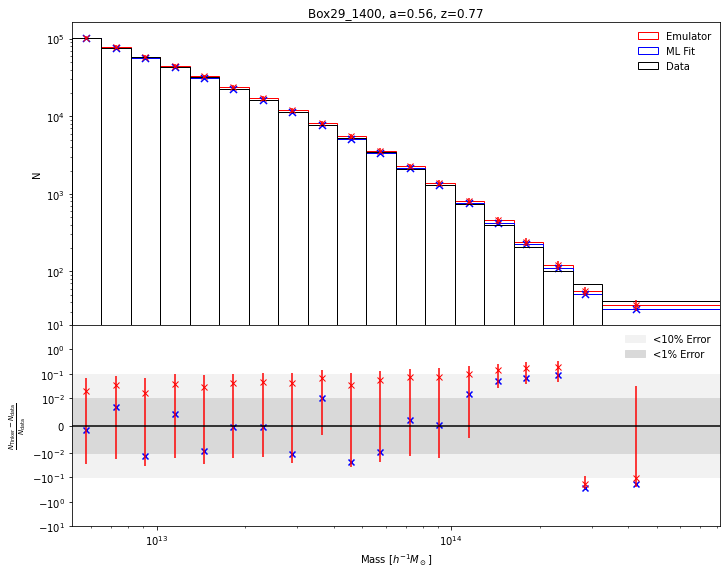

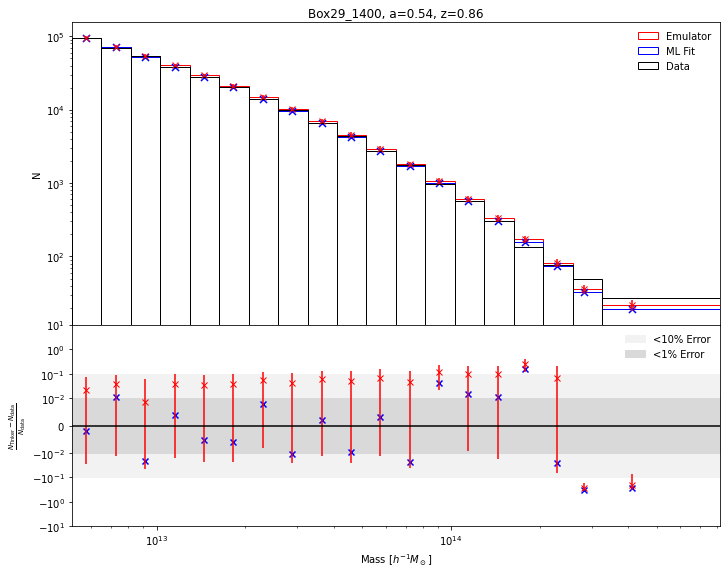

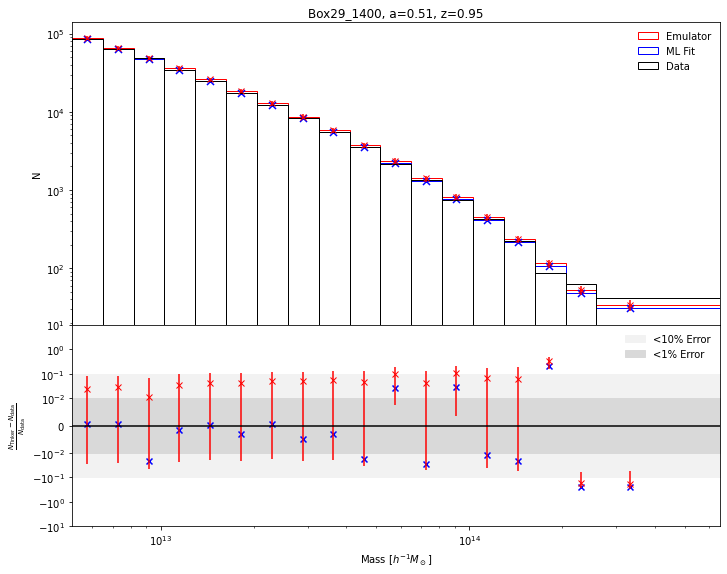

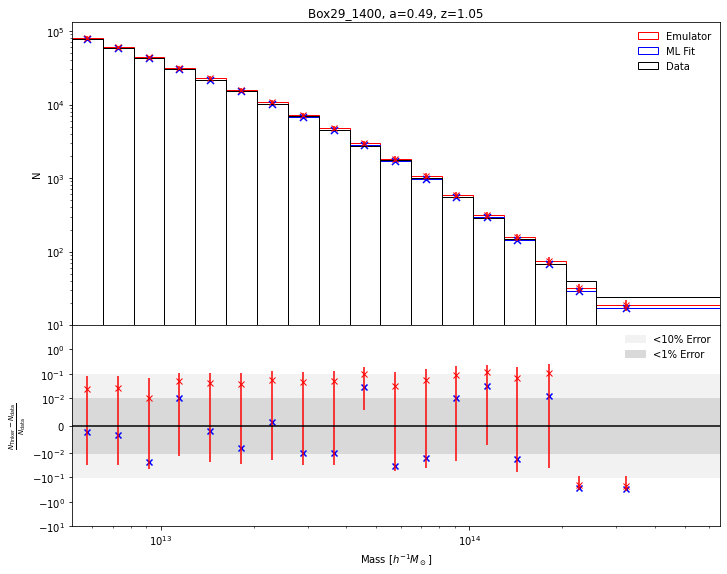

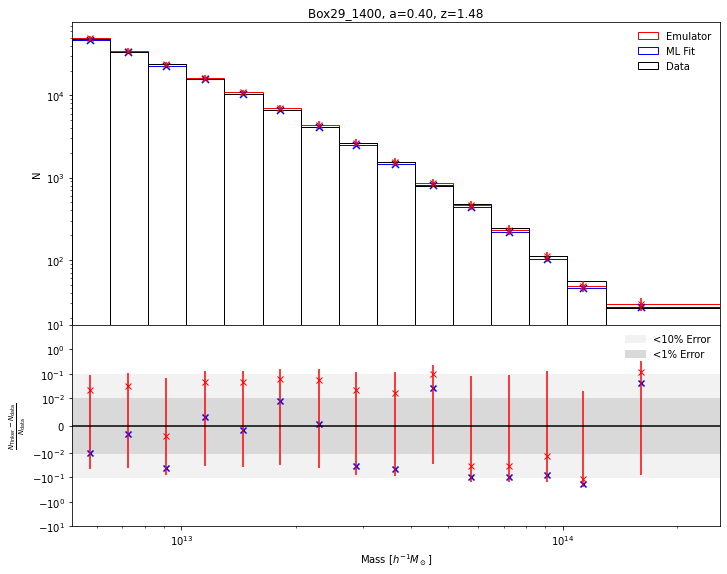

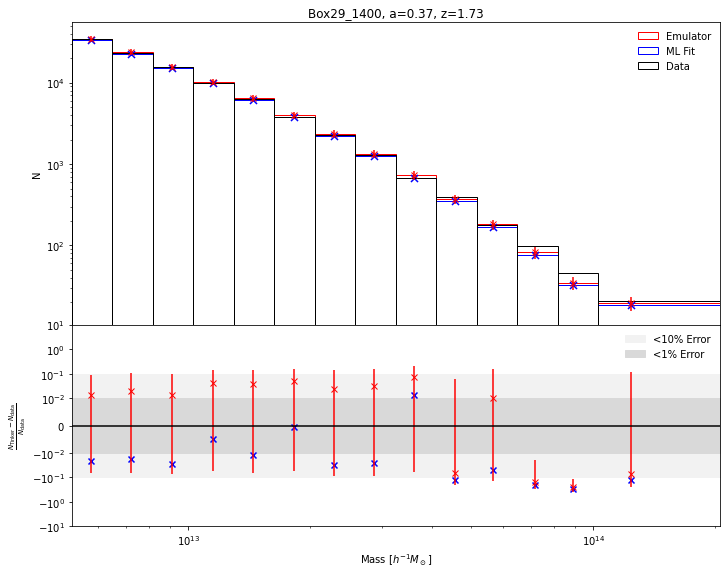

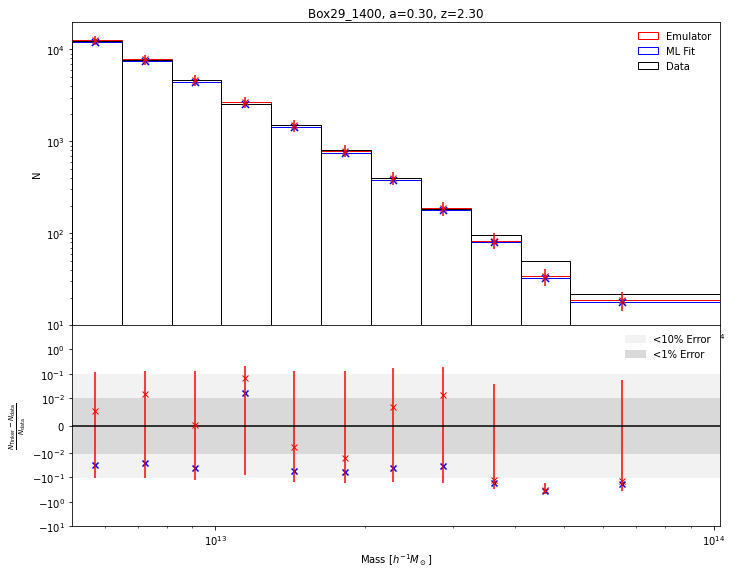

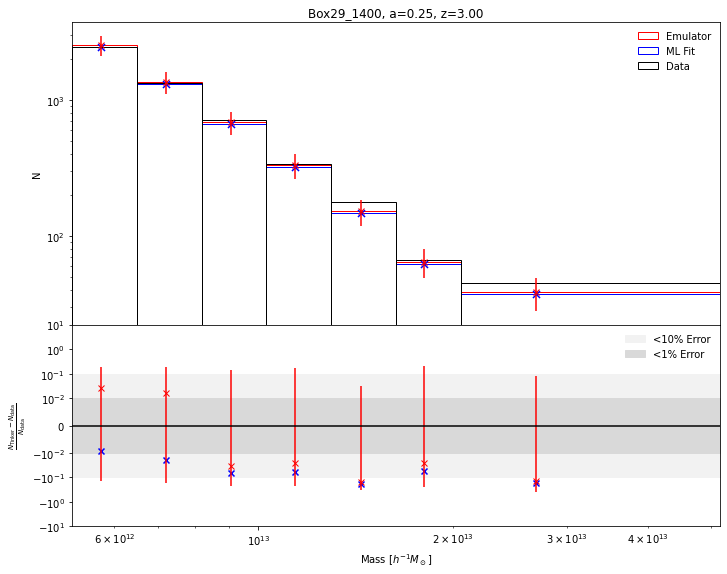

In [32]:
from multiprocessing import Pool

def estimate_uncertainty(param_combo):
    c_params = dict(zip(param_names, param_combo)) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    return tinker_eval_MCMC

for a in reversed(N_data):

    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = mass_function.Pka[a]
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])

    

    #get uncertainty in emulator prediction
    pool = Pool()
    uncertainty_estimate = list(tqdm(pool.imap(estimate_uncertainty, samples[box]), 
                                     total=len(samples[box])))    
    emulator_uncertainty = np.std(uncertainty_estimate, axis=0)



    #Emulator 
    c_params = dict(zip(param_names, mean[box])) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    axs[0].errorbar(Ms, tinker_eval_MCMC, emulator_uncertainty, fmt='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='red', label='Emulator')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, emulator_uncertainty/N, fmt='x', color='red')

    #ML Fit
    c_params = dict(zip(param_names, Y_test[np.where(box_test==box)][0])) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='blue')

    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('symlog', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))
    i+=1

    axs[0].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_ylim((-1e1, 1e1))
    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')